## Simulate Centralized Multi Robot system

In [1]:
from jax import Array, jit
import jax.numpy as jnp
import numpy as np
from cbfkit.codegen.create_new_system import generate_model

In [2]:
target_directory = "./tutorials"
model_name = "multi_augmented_single_integrators"

### 1. Simulation setup

In [3]:
num_robots = 10 
INITIAL_STATE = np.zeros(2 * num_robots)
goals = np.zeros(2 * num_robots)
DT = 0.1 
TF = 10 
N_STEPS = int(TF / DT) + 1
ACTUATION_LIMITS = 100 * jnp.ones(
    2 * num_robots
)

# Set initial states and goals of all the robots
# The robot states are appended in a single vector
for i in range(num_robots):
    theta_disturbance = np.clip(np.random.normal(0, 1.0), -np.pi / 60, np.pi / 60)
    INITIAL_STATE[2 * i] = 2 * np.cos(2 * np.pi * i / num_robots + theta_disturbance)
    INITIAL_STATE[2 * i + 1] = 2 * np.sin(2 * np.pi * i / num_robots + theta_disturbance)
    goals[2 * i] = -2 * np.cos(2 * np.pi * i / num_robots) + 0.1
### 1. Simulation setup    goals[2 * i + 1] = -2 * np.sin(2 * np.pi * i / num_robots) + 0.1

### 2. Set robot dynamics

The following example assumes single integrator dynamics for all the robots.

In [4]:
drift_dynamics_single_robot = np.array([0, 0])
drift_dynamics = np.tile(drift_dynamics_single_robot, num_robots)
drift_dynamics = np.array2string(drift_dynamics, separator=",").replace("\n", "")

control_matrix_single_robot = np.eye(2) 
control_matrix = np.kron(np.eye(num_robots), control_matrix_single_robot)
control_matrix = np.array2string(control_matrix, separator=",").replace("\n", "")

# Initialize params. If dynamics had any parameters, they can be passed here too
params = {}  # {"dynamics": {"epsilon: float": 0.5}}

### 3. Set nominal controller

In [5]:
nominal_control_law = "["
for i in range(num_robots):
    if i < (num_robots - 1):
        nominal_control_law = (
            nominal_control_law
            + f" -k_p * (x[{2*i}]-goal[{2*i}]), -k_p * (x[{2*i+1}]-goal[{2*i+1}]),"
        )
    else:
        nominal_control_law = (
            nominal_control_law
            + f" -k_p * (x[{2*i}]-goal[{2*i}]), -k_p * (x[{2*i+1}]-goal[{2*i+1}])"
        )
nominal_control_law = nominal_control_law + "]"
params["controller"] = {
    "goal: float": goals,
    "k_p: float": 1.0,
}

### 4. Define constraint functions

In [6]:
state_constraint_funcs = []
for i in range(num_robots):
    for j in range(i + 1, num_robots):
        state_constraint_funcs.append(f"(x[{2*i}]-x[{2*j}])**2 + (x[{2*i+1}]-x[{2*j+1}])**2 - 1")

### 5. Define lyapunov functions: one for each robot

In [7]:
params["clf"] = []
lyapunov_functions = []
for i in range(num_robots):
    lyapunov_functions.append(f"(x[{2*i}]-goal[0])**2+(x[{2*i+1}]-goal[1])**2")
    params["clf"].append(
        {
            "goal: float": goals[2 * i : 2 * i + 2],
        }
    )

### 6. Generate model files automatically using cbfkit

In [8]:
generate_model.generate_model(
    directory=target_directory,
    model_name=model_name,
    drift_dynamics=drift_dynamics,
    control_matrix=control_matrix,
    barrier_funcs=state_constraint_funcs,
    lyapunov_funcs=lyapunov_functions,
    nominal_controller=nominal_control_law,
    params=params,
)

Generated ROS2 controller node script at ./tutorials/multi_augmented_single_integrators/ros2/controller.py
Generated ROS2 sensor node script at ./tutorials/multi_augmented_single_integrators/ros2/sensor.py
Generated ROS2 estimator node script at ./tutorials/multi_augmented_single_integrators/ros2/estimator.py
Generated ROS2 plant node script at ./tutorials/multi_augmented_single_integrators/ros2/plant_model.py
Generated configuration script at ./tutorials/multi_augmented_single_integrators/ros2/config.py
Generated bash script to run ROS2 nodes at: ./tutorials/multi_augmented_single_integrators/run_ros2_nodes.sh


(20, 20)

### 7. Import generated files

In [9]:
# Provides access to execute (sim.execute)
import cbfkit.simulation.simulator as sim

# Access to CBF-CLF-QP control law
import cbfkit.controllers_and_planners.model_based.cbf_clf_controllers as cbf_clf_controllers

# Necessary housekeeping for using multiple CBFs/CLFs
from cbfkit.controllers_and_planners.model_based.cbf_clf_controllers.utils.certificate_packager import (
    concatenate_certificates,
)

# Suite of zeroing barrier function derivative conditions (forms of Class K functions)
from cbfkit.controllers_and_planners.model_based.cbf_clf_controllers.utils.barrier_conditions import (
    zeroing_barriers,
)

# Exponentially stable derivative condition for CLF
from cbfkit.controllers_and_planners.model_based.cbf_clf_controllers.utils.lyapunov_conditions.exponential_stability import (
    e_s,
)

# Assuming perfect, complete state information
from cbfkit.sensors import perfect as sensor

# With perfect sensing, we can use a naive estimate of the state
from cbfkit.estimators import naive as estimator

# Use forward-Euler numerical integration scheme
from cbfkit.utils.numerical_integration import forward_euler as integrator

from tutorials import multi_augmented_single_integrators

# Simulation Parameters
SAVE_FILE = f"tutorials/{model_name}/simulation_data"  # automatically uses .csv format

### 8. Include all CBFs and CLFs in a single list. required for cbfkit interface. the code below can be made part of library 

In [10]:
bs = []
for i in range(len(state_constraint_funcs)):
    func_name = (
        "multi_augmented_single_integrators.certificate_functions.barrier_functions."
        + "cbf"
        + str(i + 1)
        + "_package"
    )
    exec(f"func={func_name}")
    bs.append(func(certificate_conditions=zeroing_barriers.linear_class_k(alpha=1.0)))
barriers = concatenate_certificates(*bs)

ls = []
for i in range(len(lyapunov_functions)):
    func_name = (
        "multi_augmented_single_integrators.certificate_functions.lyapunov_functions."
        + "clf"
        + str(i + 1)
        + "_package"
    )
    exec(f"func={func_name}")
    # func = getattr(__main__, func_name)
    ls.append(
        func(
            certificate_conditions=e_s(c=2.0),
            goal=goals[2 * i : 2 * i + 2],
        )
    )
lyapunov = concatenate_certificates(*ls)

### 9. Define nominal controller and CBF-QP controller

In [11]:
dynamics = (
    multi_augmented_single_integrators.plant()
) 

nominal_controller = multi_augmented_single_integrators.controllers.controller_1(
    goal=goals, k_p=1
) 

cbf_clf_controller = cbf_clf_controllers.vanilla_cbf_clf_qp_controller(
    control_limits=ACTUATION_LIMITS,
    nominal_input=nominal_controller,
    dynamics_func=dynamics,
    barriers=barriers,
    lyapunovs=lyapunov,
    relaxable_clf=True,
)

### Simulate the system

In [12]:
x, _u, _z, _p, dkeys, dvalues = sim.execute(
    x0=INITIAL_STATE,
    dt=DT,
    num_steps=N_STEPS,
    dynamics=dynamics,
    integrator=integrator,
    controller=cbf_clf_controller,
    sensor=sensor,
    estimator=estimator,  # perturbation=generate_stochastic_perturbation(sigma=sigma, dt=DT),
    filepath=SAVE_FILE,
)

 47%|████▋     | 47/101 [00:07<00:08,  6.64it/s]


CONTROLLER ERROR


### Generate GIF

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter imagemagick unavailable; using Pillow instead.


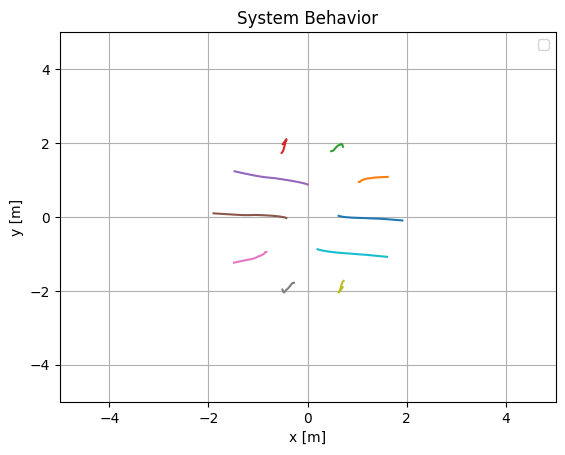

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'System Behavior'}, xlabel='x [m]', ylabel='y [m]'>)

In [13]:
from tutorials.plot_multi_single_integrators import animate

animate(
    states=x,
    estimates=_z,
    desired_state=goals,
    desired_state_radius=0.1,
    x_lim=(-5, 5),
    y_lim=(-5, 5),
    dt=DT,
    title="System Behavior",
    save_animation=True,
    animation_filename=target_directory + "/" + model_name + "/animation" + ".gif",
    num_robots=num_robots,
)